In [16]:
import pandas as pd
import geopandas as gpd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
from joblib import Parallel, delayed
from tqdm import tqdm

In [46]:
full_preds = pd.read_csv("v1_train_grid.csv")

In [47]:
full_preds = gpd.GeoDataFrame(full_preds, 
                              geometry=gpd.points_from_xy(full_preds['longitude'], full_preds['latitude']),
                             crs="EPSG:4326")

In [48]:
with open("../grid_large_std.pkl", "rb") as f:
    grid_large = pickle.load(f)

In [49]:
grid = gpd.read_file("../grid.gpkg")

In [50]:
grid.to_crs(full_preds.crs, inplace=True)

In [51]:
combined = gpd.sjoin(grid, full_preds, how="inner", predicate="contains")

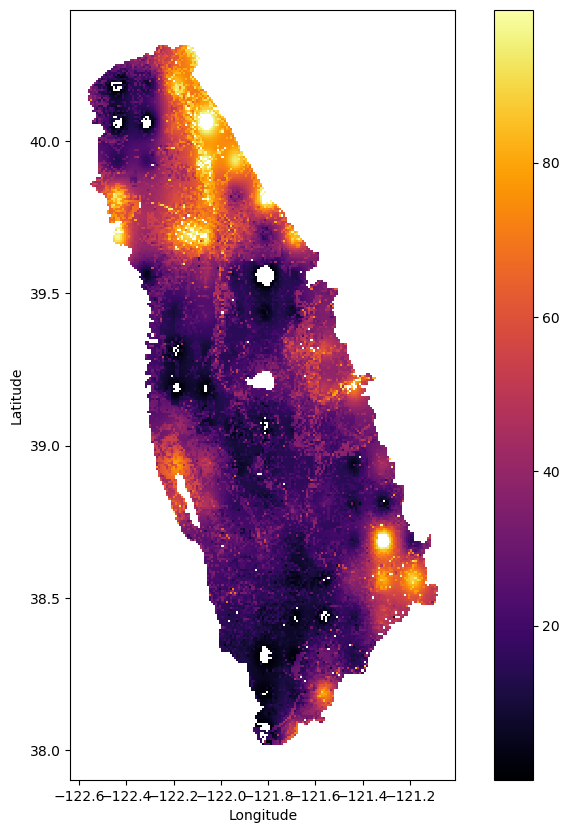

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))
combined.loc[(combined['pred'] < 0) | (combined['pred'] > 100), 'pred'] = np.nan
combined.plot(column='pred', cmap='inferno', ax=ax, legend=True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

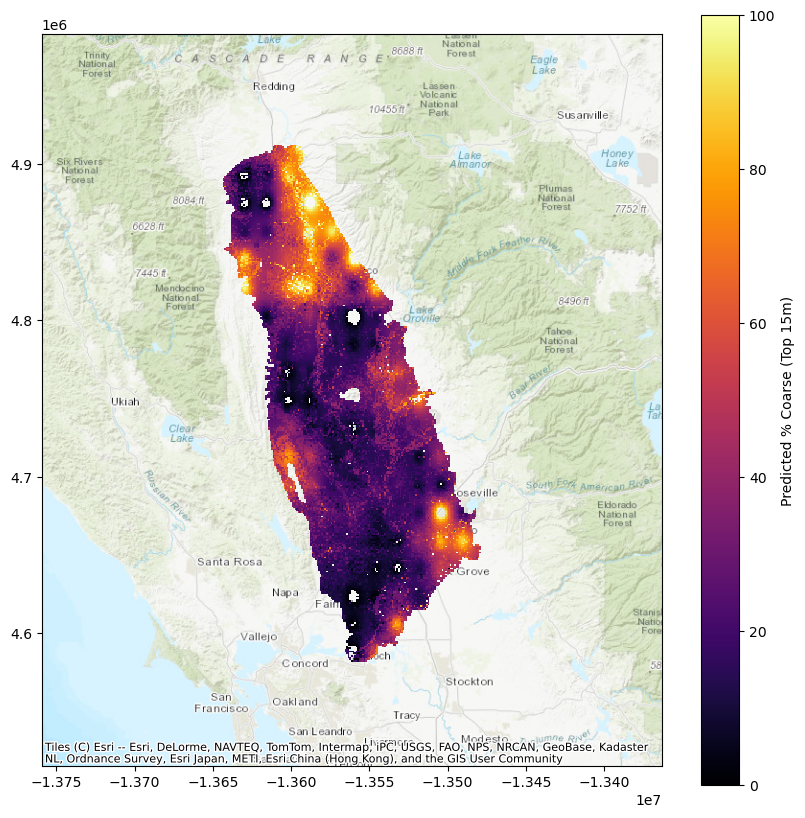

In [53]:
combined = combined.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10, 10))

combined.loc[(combined['pred'] < 0) | (combined['pred'] > 100), 'pred'] = np.nan

combined.plot(
    column='pred',
    cmap='inferno',
    ax=ax,
    legend=True,
    vmin=0,
    vmax=100,
    legend_kwds={'ticks': [0, 20, 40, 60, 80, 100],
                'label':"Predicted % Coarse (Top 15m)"}
)

xmin, ymin, xmax, ymax = combined.total_bounds
x_buffer = (xmax - xmin) * 0.7
y_buffer = (ymax - ymin) * 0.2

ax.set_xlim(xmin - x_buffer, xmax + x_buffer)
ax.set_ylim(ymin - y_buffer, ymax + y_buffer)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTopoMap)

plt.show()

In [54]:
[x for x in grid_large.columns if "Developed" in x]

['cdl_category_2010_Developed/High Intensity',
 'cdl_category_2010_Developed/Low Intensity',
 'cdl_category_2010_Developed/Medium Intensity',
 'cdl_category_2010_Developed/Open Space',
 'cdl_category_2015_Developed/High Intensity',
 'cdl_category_2015_Developed/Low Intensity',
 'cdl_category_2015_Developed/Medium Intensity',
 'cdl_category_2015_Developed/Open Space',
 'cdl_category_2020_Developed/High Intensity',
 'cdl_category_2020_Developed/Low Intensity',
 'cdl_category_2020_Developed/Medium Intensity',
 'cdl_category_2020_Developed/Open Space']

In [55]:
developed = [x for x in grid_large.columns if any(["Developed/High Intensity" in x, "Developed/Medium Intensity" in x])]

In [56]:
grid_large_undeveloped = grid_large[(grid_large[developed] == 0).all(axis=1)]

In [57]:
non_dev = grid_large_undeveloped.unary_union

/tmp/ipykernel_1522120/3154370416.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  non_dev = grid_large_undeveloped.unary_union


In [58]:
def check_within(geom, non_dev_geom):
    return geom.within(non_dev_geom)
    
results = Parallel(n_jobs=-1)(
    delayed(check_within)(geom, non_dev) for geom in tqdm(combined.geometry, total=len(combined))
)

mask = np.array(results)
combined_nonDev = combined[mask]

100%|██████████| 26413/26413 [00:06<00:00, 4026.88it/s]


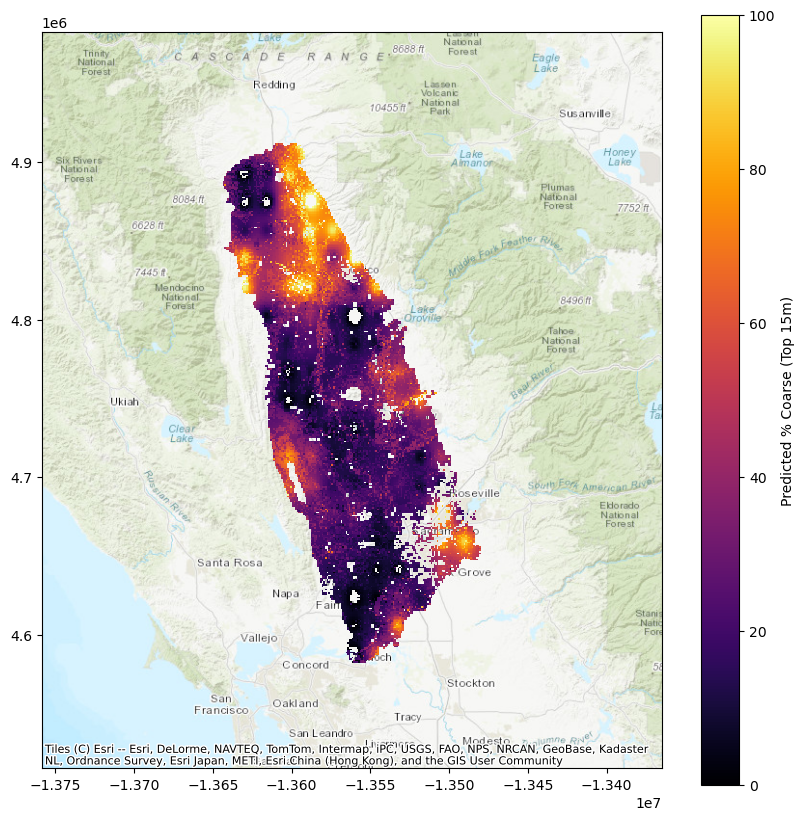

In [59]:
combined_nonDev = combined_nonDev.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10, 10))

combined_nonDev.loc[(combined_nonDev['pred'] < 0) | (combined_nonDev['pred'] > 100), 'pred'] = np.nan

combined_nonDev.plot(
    column='pred',
    cmap='inferno',
    ax=ax,
    legend=True,
    vmin=0,
    vmax=100,
    legend_kwds={'ticks': [0, 20, 40, 60, 80, 100],
                'label':"Predicted % Coarse (Top 15m)"}
)

xmin, ymin, xmax, ymax = combined_nonDev.total_bounds
x_buffer = (xmax - xmin) * 0.7
y_buffer = (ymax - ymin) * 0.2

ax.set_xlim(xmin - x_buffer, xmax + x_buffer)
ax.set_ylim(ymin - y_buffer, ymax + y_buffer)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTopoMap)

plt.show()